In [1]:
] activate .

In [2]:
include("../src/StableDQMC.jl")
using .StableDQMC

In [3]:
using GenericSVD, JacobiSVD, LinearAlgebra, Plots

pyplot();
PyPlot.plt.style.use("publication_tex")
default(
    framestyle = :box,
    legend = true,
    grid = false,
    size = (1.6*360, 360),
    xtickfont=font(13), 
    ytickfont=font(13), 
    guidefont=font(18),
    legendfont=font(12),
    linewidth = 1.5
);

# default(
#     framestyle = :box,
#     legend = true,
#     grid = false,
#     size = (1.5*250, 250),
#     xtickfont=font(8), 
#     ytickfont=font(8), 
#     guidefont=font(11),
#     legendfont=font(8),
#     linewidth = 1
# );

In [5]:
# Some basic tests
B = rand(5,5) # regular matrix
N = 10
@assert isapprox(StableDQMC.calc_product_chain(B, N)[1], B^N)
@assert isapprox(StableDQMC.calc_product_chain_stabilized(B, N, gesdd)[1], B^N)
@assert isapprox(StableDQMC.calc_product_chain_stabilized(B, N, gesvd)[1], B^N)
@assert isapprox(StableDQMC.calc_product_chain_stabilized(B, N, genericsvd)[1], B^N)
@assert isapprox(StableDQMC.calc_product_chain_stabilized(B, N, decompose_udt)[1], B^N)
# @assert isapprox(StableDQMC.calc_product_chain_stabilized(B, N, gesvj)[1], B^N)

# B from spin-fermion model

In [6]:
B = [0.975173 0.0971936 0.192475 0.0191836 0.0 0.0 0.0 0.0; 0.0971936 0.975173 0.0191836 0.192475 0.0 0.0 0.0 0.0; 0.192475 0.0191836 0.975173 0.0971936 0.0 0.0 0.0 0.0; 0.0191836 0.192475 0.0971936 0.975173 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.975173 -0.192475 -0.0971936 0.0191836; 0.0 0.0 0.0 0.0 -0.192475 0.975173 0.0191836 -0.0971936; 0.0 0.0 0.0 0.0 -0.0971936 0.0191836 0.975173 -0.192475; 0.0 0.0 0.0 0.0 0.0191836 -0.0971936 -0.192475 0.975173]

8×8 Array{Float64,2}:
 0.975173   0.0971936  0.192475   …   0.0         0.0         0.0      
 0.0971936  0.975173   0.0191836      0.0         0.0         0.0      
 0.192475   0.0191836  0.975173       0.0         0.0         0.0      
 0.0191836  0.192475   0.0971936      0.0         0.0         0.0      
 0.0        0.0        0.0           -0.192475   -0.0971936   0.0191836
 0.0        0.0        0.0        …   0.975173    0.0191836  -0.0971936
 0.0        0.0        0.0            0.0191836   0.975173   -0.192475 
 0.0        0.0        0.0           -0.0971936  -0.192475    0.975173 

In [10]:
Bbig = BigFloat.(B)
N = 400

setprecision(100) do
    global svs_genericsvd = StableDQMC.calc_product_chain_stabilized(Bbig, N, genericsvd)[2];
end
svs_qr_udt = StableDQMC.calc_product_chain_stabilized(B, N, decompose_udt)[2];
svs_gesvd = StableDQMC.calc_product_chain_stabilized(B, N, gesvd)[2];
svs_gesdd = StableDQMC.calc_product_chain_stabilized(B, N, gesdd)[2];
svs_gesvj = StableDQMC.calc_product_chain_stabilized(B, N, gesvj)[2];

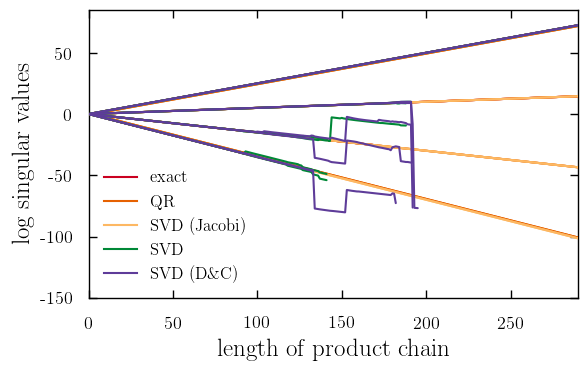

C:\Users\carsten\Anaconda2\envs\py35\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


In [11]:
plot(svs_genericsvd, color="#CA0020", labels = reshape(["exact", "", "","", "","", "", ""], (1,8)))
plot!(svs_qr_udt, color="#E66101", labels = reshape(["QR", "", "","", "","", "", ""], (1,8)))
plot!(svs_gesvj, color="#FDB863", labels = reshape(["SVD (Jacobi)", "", "","", "","", "", ""], (1,8)))
plot!(svs_gesvd, color="#008837", labels = reshape(["SVD", "", "","", "","", "", ""], (1,8)))
plot!(svs_gesdd, color="#5E3C99", labels = reshape(["SVD (D\\&C)", "", "","", "","", "", ""], (1,8)))

ylabel!("log singular values")
xlabel!("length of product chain")
ylims!(-150, 85)
xlims!((0., 290.))
savefig("decomp_comparison.pdf")

# Non-interacting system

In [12]:
n = 8
T = diagm(-1 => fill(1, n-1), 1 => fill(1, n-1), 0 => fill(-0.1, n))

8×8 Array{Float64,2}:
 -0.1   1.0   0.0   0.0   0.0   0.0   0.0   0.0
  1.0  -0.1   1.0   0.0   0.0   0.0   0.0   0.0
  0.0   1.0  -0.1   1.0   0.0   0.0   0.0   0.0
  0.0   0.0   1.0  -0.1   1.0   0.0   0.0   0.0
  0.0   0.0   0.0   1.0  -0.1   1.0   0.0   0.0
  0.0   0.0   0.0   0.0   1.0  -0.1   1.0   0.0
  0.0   0.0   0.0   0.0   0.0   1.0  -0.1   1.0
  0.0   0.0   0.0   0.0   0.0   0.0   1.0  -0.1

In [16]:
B = exp(-0.1 .* T)

8×8 Array{Float64,2}:
  1.01511      -0.101342      0.00506289   …   1.4046e-9    -2.006e-11  
 -0.101342      1.02017      -0.101511        -8.43112e-8    1.4046e-9  
  0.00506289   -0.101511      1.02018          4.21697e-6   -8.42912e-8 
 -0.000168679   0.0050671    -0.101511        -0.000168763   4.21556e-6 
  4.21556e-6   -0.000168763   0.00506711       0.0050671    -0.000168679
 -8.42912e-8    4.21697e-6   -0.000168763  …  -0.101511      0.00506289 
  1.4046e-9    -8.43112e-8    4.21697e-6       1.02017      -0.101342   
 -2.006e-11     1.4046e-9    -8.42912e-8      -0.101342      1.01511    

In [17]:
Bbig = BigFloat.(B)
N = 500

setprecision(100) do
    global svs_genericsvd = StableDQMC.calc_product_chain_stabilized(Bbig, N, genericsvd)[2];
end
svs_qr_udt = StableDQMC.calc_product_chain_stabilized(B, N, decompose_udt)[2];
svs_gesvd = StableDQMC.calc_product_chain_stabilized(B, N, gesvd)[2];
svs_gesdd = StableDQMC.calc_product_chain_stabilized(B, N, gesdd)[2];
svs_gesvj = StableDQMC.calc_product_chain_stabilized(B, N, gesvj)[2];

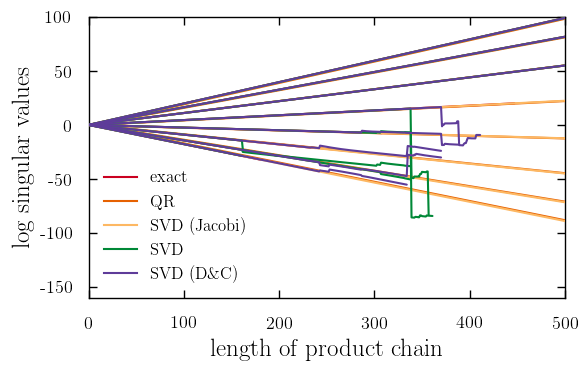

In [18]:
plot(svs_genericsvd, color="#CA0020", labels = reshape(["exact", "", "","", "","", "", ""], (1,8)))
plot!(svs_qr_udt, color="#E66101", labels = reshape(["QR", "", "","", "","", "", ""], (1,8)))
plot!(svs_gesvj, color="#FDB863", labels = reshape(["SVD (Jacobi)", "", "","", "","", "", ""], (1,8)))
plot!(svs_gesvd, color="#008837", labels = reshape(["SVD", "", "","", "","", "", ""], (1,8)))
plot!(svs_gesdd, color="#5E3C99", labels = reshape(["SVD (D\\&C)", "", "","", "","", "", ""], (1,8)))

ylabel!("log singular values")
xlabel!("length of product chain")
ylims!(-160, 100)
xlims!(0., 500.)
savefig("decomp_comparison_simple.pdf")

## Stabilization - principle issue

In [19]:
svs_naive = StableDQMC.calc_product_chain(B, N)[2]

500×8 Array{Float64,2}:
  0.197939   0.163209   0.11     0.0447296  …  -0.09    -0.143209  -0.177939
  0.395877   0.326418   0.22     0.0894593     -0.18    -0.286418  -0.355877
  0.593816   0.489627   0.33     0.134189      -0.27    -0.429627  -0.533816
  0.791754   0.652836   0.44     0.178919      -0.36    -0.572836  -0.711754
  0.989693   0.816044   0.55     0.223648      -0.45    -0.716044  -0.889693
  1.18763    0.979253   0.66     0.268378   …  -0.54    -0.859253  -1.06763 
  1.38557    1.14246    0.77     0.313107      -0.63    -1.00246   -1.24557 
  1.58351    1.30567    0.88     0.357837      -0.72    -1.14567   -1.42351 
  1.78145    1.46888    0.99     0.402567      -0.81    -1.28888   -1.60145 
  1.97939    1.63209    1.1      0.447296      -0.9     -1.43209   -1.77939 
  2.17732    1.7953     1.21     0.492026   …  -0.99    -1.5753    -1.95732 
  2.37526    1.95851    1.32     0.536756      -1.08    -1.71851   -2.13526 
  2.5732     2.12172    1.43     0.581485      -1.17

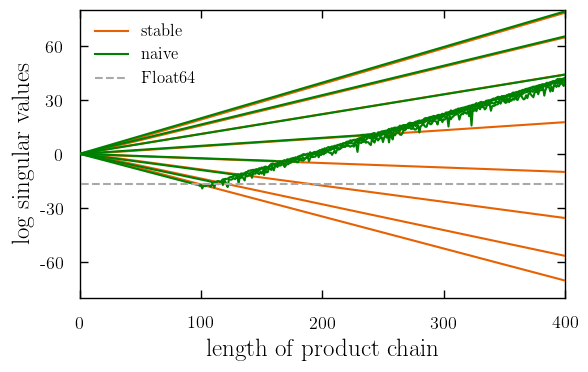

In [20]:
# plot(svs_genericsvd, color="#CA0020", labels = reshape(["exact", "", "","", "","", "", ""], (1,8)))
plot(svs_qr_udt, color="#E66101", labels = reshape(["stable", "", "","", "","", "", ""], (1,8)))
plot!(svs_naive, color=:green, labels = reshape(["naive", "", "","", "","", "", ""], (1,8)))
plot!(1:400, fill(-17, 400), color=:darkgray, linestyle=:dash, label = "Float64")

ylabel!("log singular values")
xlabel!("length of product chain")

ylims!(-80, 80)
xlims!((0., 400.))
savefig("naive_vs_stable.pdf")

In [21]:
using DoubleFloats
Bdb64 = Double64.(B)
svs_naive = StableDQMC.calc_product_chain(Bdb64, N)[2]

500×8 Array{DoubleFloat{Float64},2}:
  0.19793852415718174   0.16320888862379554  …    -0.1779385241571816
  0.3958770483143635    0.3264177772475911        -0.3558770483143632
  0.5938155724715453    0.48962666587138665       -0.5338155724715448
  0.791754096628727     0.6528355544951822        -0.7117540966287264
  0.9896926207859087    0.8160444431189777        -0.8896926207859079
  1.1876311449430905    0.9792533317427733   …    -1.0676311449430895
  1.3855696691002721    1.1424622203665689        -1.2455696691002711
  1.583508193257454     1.3056711089903643        -1.4235081932574527
  1.7814467174146356    1.46887999761416          -1.6014467174146343
  1.9793852415718174    1.6320888862379554        -1.7793852415718159
  2.177323765728999     1.7952977748617511   …    -1.9573237657289975
  2.375262289886181     1.9585066634855466        -2.135262289886179 
  2.5732008140433624    2.1217155521093423        -2.3132008140433604
  ⋮                                          ⋱       

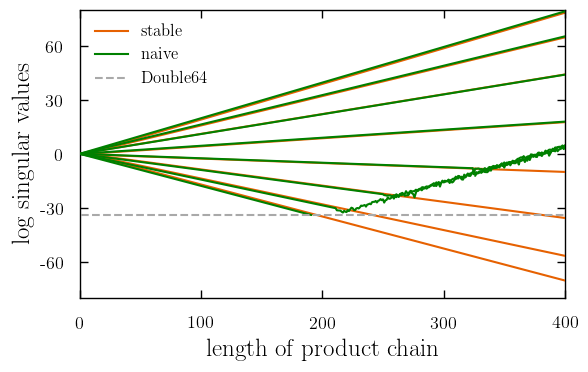

In [22]:
# plot(svs_genericsvd, color="#CA0020", labels = reshape(["exact", "", "","", "","", "", ""], (1,8)))
plot(svs_qr_udt, color="#E66101", labels = reshape(["stable", "", "","", "","", "", ""], (1,8)))
plot!(svs_naive, color=:green, labels = reshape(["naive", "", "","", "","", "", ""], (1,8)))
plot!(1:400, fill(-34, 400), color=:darkgray, linestyle=:dash, label = "Double64")

ylabel!("log singular values")
xlabel!("length of product chain")
ylims!(-80, 80)
xlims!((0., 400.))
# savefig("naive_vs_stable_db64.pdf")

# PyPlot

In [ ]:
# using PyPlot
# plt.style.use("publication_tex")
# function Inf2NaN(x)
#     y = copy(x)
#     y[findall(i -> (i == Inf || i == -Inf), y)] .= NaN
#     y = Float64.(y)
# end

# # PyPlot
# plot(Inf2NaN(svs_genericsvd), color="#CA0020", lw=2, label = "exact")
# plot(svs_qr_udt, color="#E66101", lw=2, label = "QR")
# plot(svs_gesvj, color="#FDB863", lw=2, label = "SVD (Jacobi)")
# plot(svs_gesvd, color="#008837", lw=2, label = "SVD")
# plot(svs_gesdd, color="#5E3C99", lw=2, label = "SVD (D\\&C)")

# handles, labels = gca().get_legend_handles_labels()
# ulabels = unique(labels)
# uhandles = Vector{eltype(handles)}(undef, 0)
# for l in ulabels
#     push!(uhandles, handles[findfirst(isequal(l), labels)])
# end
# legend(uhandles, ulabels, loc="lower left", prop=Dict("size" => 16))

# ylabel("log singular values")
# xlabel("length of product chain")
# ylim(-150, 85)
# xlim(0., 290.)
# savefig("decomp_comparison.pdf")